In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read Train data

In [2]:

train_home_team_statistics_df = pd.read_csv('../X_Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('../X_Train_Data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('../Y_train_1rknArQ.csv', index_col=0)

train_supp = pd.read_csv('Y_train_supp.csv', index_col=0)
goal_diff = train_supp['GOAL_DIFF_HOME_AWAY']


train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [3]:
train_home_team_statistics_df.head()

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


In [4]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


## Benchmark

We try to model on all possible results of a match

In [3]:
train_new_y = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].values.argmax(axis=1)


### train, valid test split

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


### xgb model

In [5]:
params_1 = {
    'objective': 'multi:softprob',
    'num_class': 3,  
    'max_depth': 6,   
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 50
}


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:1.09649	eval-mlogloss:1.09751
[1]	train-mlogloss:1.09439	eval-mlogloss:1.09627
[2]	train-mlogloss:1.09233	eval-mlogloss:1.09514
[3]	train-mlogloss:1.09029	eval-mlogloss:1.09404
[4]	train-mlogloss:1.08823	eval-mlogloss:1.09293
[5]	train-mlogloss:1.08625	eval-mlogloss:1.09188
[6]	train-mlogloss:1.08423	eval-mlogloss:1.09091
[7]	train-mlogloss:1.08227	eval-mlogloss:1.08989
[8]	train-mlogloss:1.08032	eval-mlogloss:1.08890
[9]	train-mlogloss:1.07829	eval-mlogloss:1.08791
[10]	train-mlogloss:1.07632	eval-mlogloss:1.08694
[11]	train-mlogloss:1.07438	eval-mlogloss:1.08581
[12]	train-mlogloss:1.07245	eval-mlogloss:1.08475
[13]	train-mlogloss:1.07052	eval-mlogloss:1.08378
[14]	train-mlogloss:1.06864	eval-mlogloss:1.08284
[15]	train-mlogloss:1.06672	eval-mlogloss:1.08188
[16]	train-mlogloss:1.06479	eval-mlogloss:1.08111
[17]	train-mlogloss:1.06294	eval-mlogloss:1.08016
[18]	train-mlogloss:1.06105	eval-mlogloss:1.07927
[19]	train-mlogloss:1.05923	eval-mlogloss:1.07840
[20]	train

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
import numpy as np

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(train_data, goal_diff)

preds = model.predict(train_data)


In [7]:
def goal_diff_to_result(pred):
    if pred > 0:
        return [1, 0, 0]  # HOME_WIN
    elif pred == 0:
        return [0, 1, 0]  # DRAW
    else:
        return [0, 0, 1]  # AWAY_WIN

predicted_classes = np.array([goal_diff_to_result(p) for p in preds])
true_classes = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].values


### Some analysis

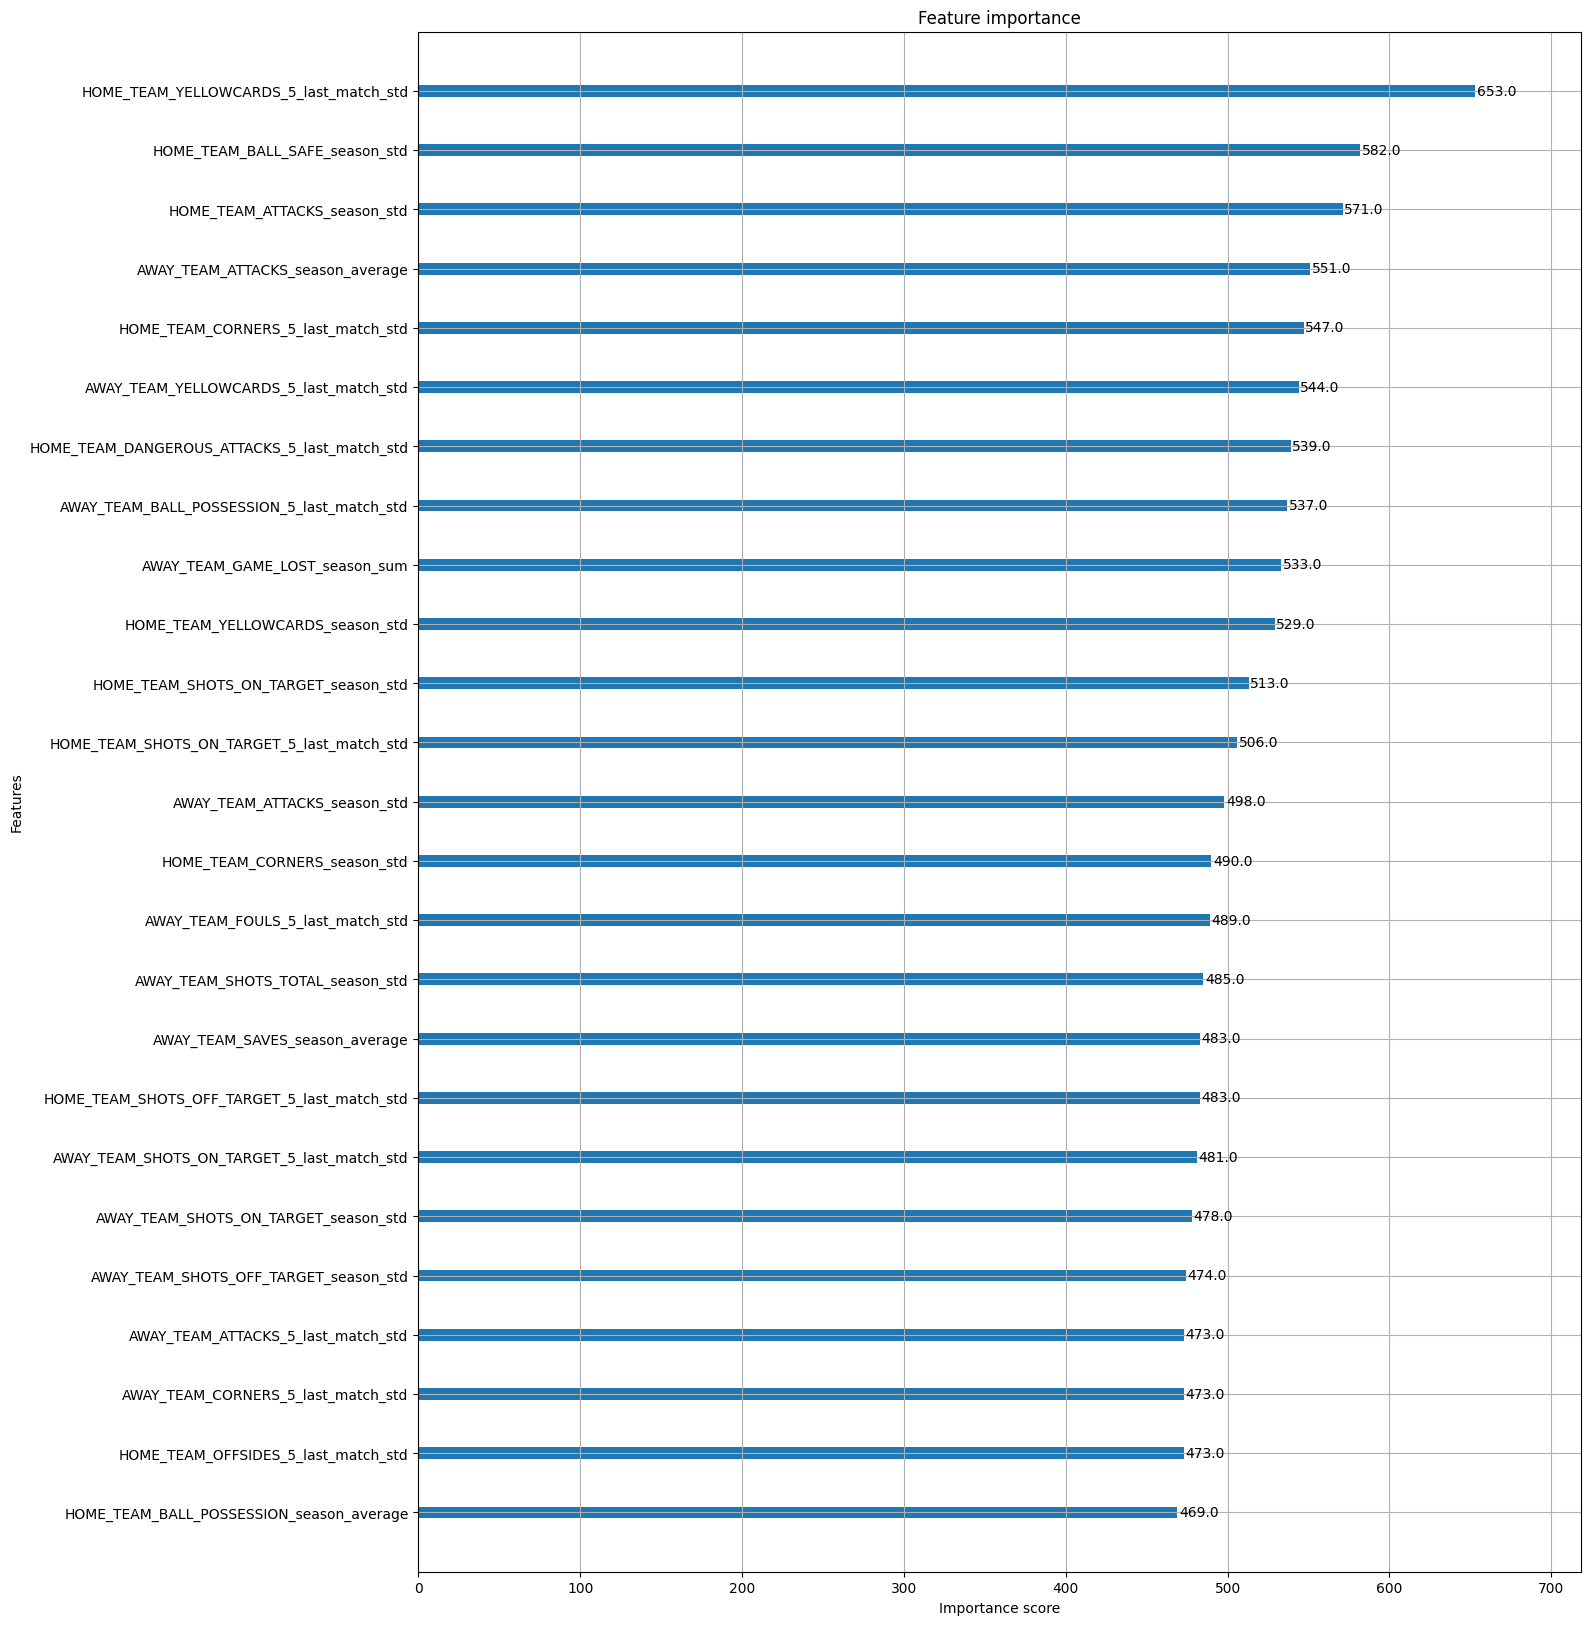

In [9]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [10]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


np.float64(0.4401)

Using our model

In [11]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


np.float64(0.473)

In [8]:
accuracy = np.mean(np.all(predicted_classes == true_classes, axis=1))
print(f"Regression-based prediction accuracy: {accuracy * 100:.2f}%")


Regression-based prediction accuracy: 60.42%


## Submission

In [9]:

test_home = pd.read_csv('../X_Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('../X_Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data = pd.concat([test_home, test_away], join='inner', axis=1)


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_optimized_correlation_heatmap(df, max_features=30, corr_threshold=0.95, figsize=(12, 10)):
    """
    Standardise le DataFrame, supprime les variables fortement corrélées
    et affiche une heatmap de corrélation optimisée et rapide à rendre.

    Paramètres :
        df (pd.DataFrame) : DataFrame contenant les variables initiales.
        max_features (int) : Nombre maximal de variables à afficher dans la heatmap.
        corr_threshold (float) : Seuil de corrélation au-dessus duquel une variable est supprimée.
        figsize (tuple) : Dimensions de la figure de la heatmap.

    Retourne :
        pd.DataFrame : DataFrame standardisé et réduit, après suppression des corrélations élevées.
    """
    
    # Standardisation des données (centrage/réduction)
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Calcul de la matrice de corrélation
    corr = scaled_df.corr()

    # Sélection de la partie supérieure de la matrice (triangle supérieur sans la diagonale)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # Liste des colonnes à supprimer car trop corrélées avec d'autres (corrélation > seuil)
    to_drop = [column for column in upper.columns if any(upper[column].abs() > corr_threshold)]

    # Suppression des colonnes trop corrélées
    reduced_df = scaled_df.drop(columns=to_drop)

    # Sélection d’un sous-ensemble des variables (au maximum max_features)
    subset = reduced_df.iloc[:, :max_features]

    # Affichage de la heatmap de corrélation
    plt.figure(figsize=figsize)
    sns.heatmap(subset.corr(), cmap="coolwarm", center=0)
    plt.title("Optimized Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # Retourne le DataFrame standardisé et réduit
    return reduced_df


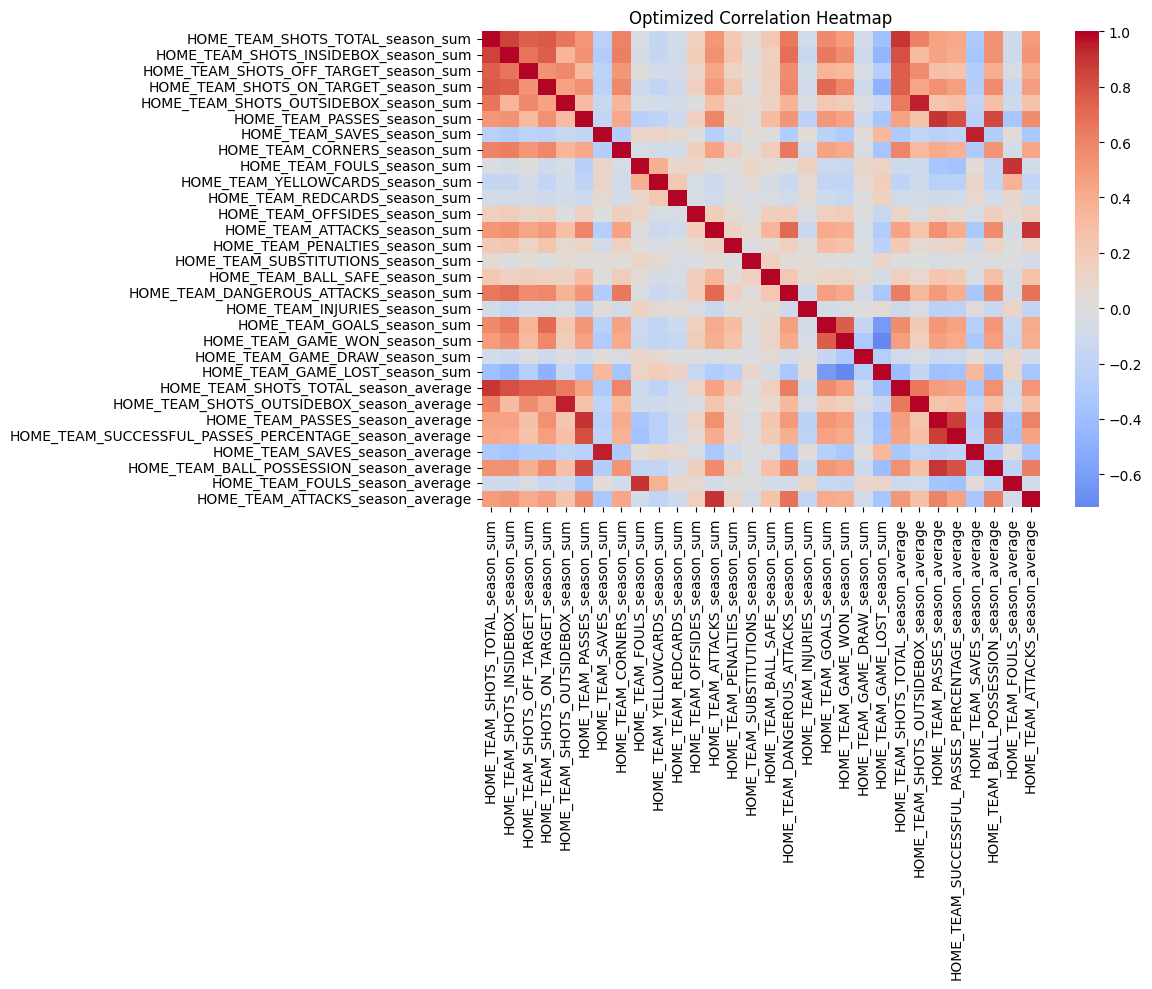

In [11]:
train_data_cleaned = plot_optimized_correlation_heatmap(train_data)

Clusters fort:
SHOTS_TOTAL, SHOTS_ON_TARGET, SHOTS_INSIDEBOX, and SHOTS_OUTSIDEBOX sont correllees positive.

GOALS, GAME_WON, ATTACKS, and DANGEROUS_ATTACKS peut-etre ont une correlation positive.

Relations negatifs:
Statistiques defensifs : FOULS, YELLOWCARDS, or INJURIES peuvent etre correllee negativement avec des statistiques performants comme GOALS ou GAME_WON.

In [12]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv('./benchmark_submission.csv', index=False)


In [13]:
test_preds = model.predict(test_data)

test_predicted_classes = np.array([goal_diff_to_result(p) for p in test_preds])

submission = pd.DataFrame(
    test_predicted_classes,
    columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'],
    index=test_data.index 
)

submission = submission[['HOME_WINS', 'DRAW', 'AWAY_WINS']]

submission = submission.reset_index()

submission.to_csv("regression_goal_diff_submission.csv", index=False)
print("Submission file saved as 'regression_goal_diff_submission.csv'")


Submission file saved as 'regression_goal_diff_submission.csv'
